In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [113]:
df = pd.read_csv("bond_yields_2000_2024.csv")
df.head()

,Date,German 10-Year Government Bond Yields (%),MRO Rate (%),US 10-Year Government Benchmark Bond Yield (%)
0,2000,5.26,4.75,6.03
1,2001,4.80,4.25,5.01
2,2002,4.78,3.25,4.60
3,2003,4.07,2.00,4.00
4,2004,4.04,2.00,4.26


# 1. Plot trends

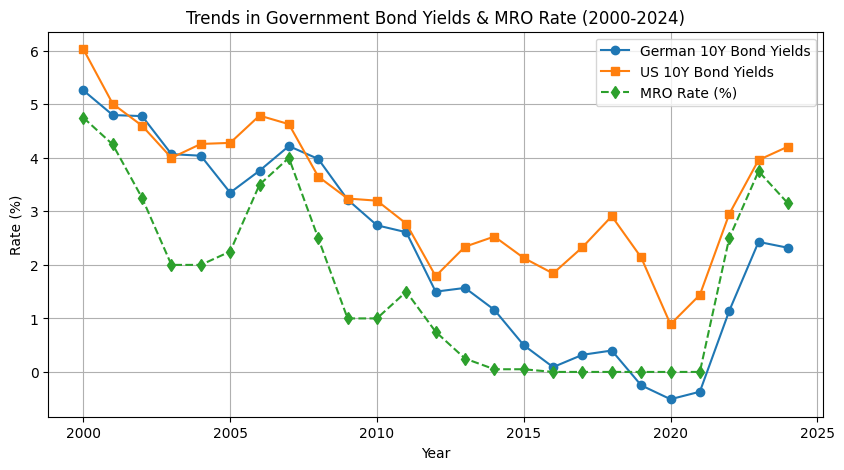

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["German 10-Year Government Bond Yields (%)"], marker='o', label="German 10Y Bond Yields")
plt.plot(df["Date"], df["US 10-Year Government Benchmark Bond Yield (%)"], marker='s', label="US 10Y Bond Yields")
plt.plot(df["Date"], df["MRO Rate (%)"], marker='d', label="MRO Rate (%)", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Rate (%)")
plt.title("Trends in Government Bond Yields & MRO Rate (2000-2024)")
plt.legend()
plt.grid()

# 2. Correlation matrix

Text(0.5, 1.0, 'Correlation Matrix of Economic Indicators')

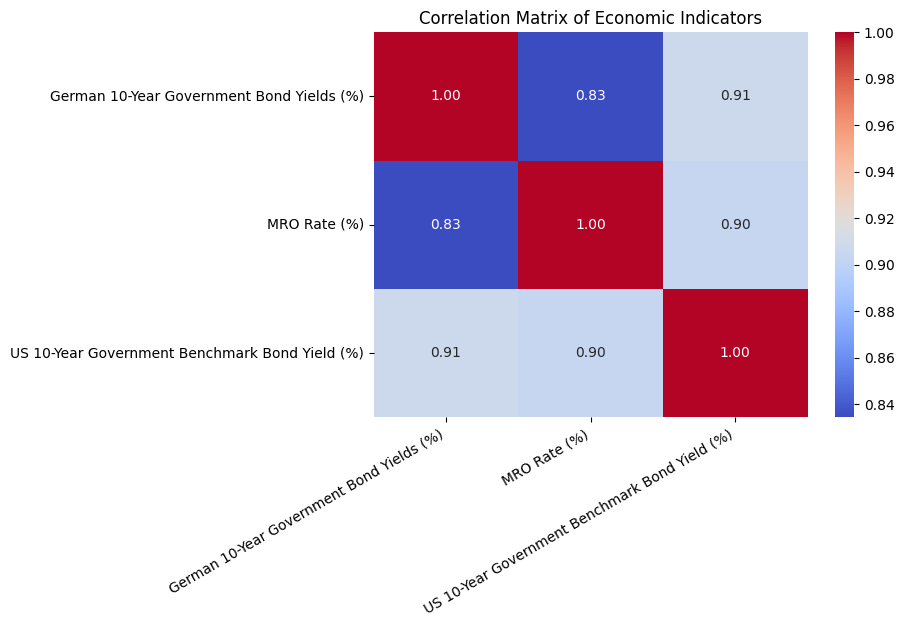

In [10]:
corr_matrix = df.drop(columns=["Date"]).corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.xticks(rotation=30, ha="right")
plt.title("Correlation Matrix of Economic Indicators")

# 3. Regression Analysis (OLS)

In [15]:
features = df[["MRO Rate (%)", "US 10-Year Government Benchmark Bond Yield (%)"]]
target = df[["German 10-Year Government Bond Yields (%)"]]

features_with_intercept = sm.add_constant(features)
model = sm.OLS(target, features_with_intercept).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     German 10-Year Government Bond Yields (%)   R-squared:                       0.824
Model:                                                   OLS   Adj. R-squared:                  0.808
Method:                                        Least Squares   F-statistic:                     51.40
Date:                                       Tue, 28 Jan 2025   Prob (F-statistic):           5.11e-09
Time:                                               18:32:12   Log-Likelihood:                -28.193
No. Observations:                                         25   AIC:                             62.39
Df Residuals:                                             22   BIC:                             66.04
Df Model:                                                  2                                         
Covariance Type:                                   nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -1.7540      0.653     -2.686      0.013      -3.108      -0.400
MRO Rate (%)                                       0.0916      0.237      0.386      0.703      -0.400       0.583
US 10-Year Government Benchmark Bond Yield (%)     1.1852      0.297      3.989      0.001       0.569       1.801
==============================================================================
Omnibus:                        4.103   Durbin-Watson:                   0.496
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                1.513
Skew:                          -0.031   Prob(JB):                        0.469
Kurtosis:                       1.796   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 4. Checking for heteroskedasticity (Breusch-Pagan test)

In [17]:
from statsmodels.stats.diagnostic import het_breuschpagan

residuals = model.resid
fitted_values = model.fittedvalues

bp_test = het_breuschpagan(residuals, features_with_intercept)
f"Breusch-Pagan Test p-value: {bp_test[1]}"

'Breusch-Pagan Test p-value: 0.9499079961005729'

## p-value is way above 0.05. Therefore, we fail to reject H0 and conclude that heteroskedasticity is not present in the model.

# 5. Checking for Autocorrelation (Durbin-Watson)

In [21]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(model.resid)

f"Durbin-Watson Test Statistic: {dw_stat}"

'Durbin-Watson Test Statistic: 0.4962255249701266'

## Durbin-Watson statistic indicates strong positive autocorrelation. To remove it, differencing will be applied

# 5.1. Time Series Transformation to remove autocorrelation

In [210]:
df_copy = df.copy()

df_copy["Diff_German_Yield"] = df_copy["German 10-Year Government Bond Yields (%)"].diff()
df_copy = df_copy.dropna()

features = df_copy[["MRO Rate (%)", "US 10-Year Government Benchmark Bond Yield (%)"]]
target = df_copy[["Diff_German_Yield"]]

features_with_intercept = sm.add_constant(features)
model = sm.OLS(target, features_with_intercept).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Diff_German_Yield   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     3.433
Date:                Tue, 28 Jan 2025   Prob (F-statistic):             0.0513
Time:                        20:20:03   Log-Likelihood:                -18.385
No. Observations:                  24   AIC:                             42.77
Df Residuals:                      21   BIC:                             46.30
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.3546      0.474      0.748      0.463      -0.631       1.340
MRO Rate (%)                                       0.3977      0.166      2.401      0.026       0.053       0.742
US 10-Year Government Benchmark Bond Yield (%)    -0.3487      0.213     -1.635      0.117      -0.792       0.095
==============================================================================
Omnibus:                        0.632   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.266
Skew:                           0.257   Prob(JB):                        0.875
Kurtosis:                       2.956   Cond. No.                         18.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 6. Check for Stationarity (ADF test)

In [87]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_copy["Diff_German_Yield"])

print(f"ADF statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("✅ Data is stationary")

ADF statistic: -3.312448152071963
p-value: 0.014331128882686235
✅ Data is stationary


## p-value < 0.05, so we reject the null hypothesis and state that data is stationary after first differencing. Now it makes sense to proceed with SARIMA.

# 7. Building SARIMA (Seasonal AutoRegressive Integrated Moving Average) model

# 7.1. Fit SARIMA model

In [211]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

df_copy["Date"] = pd.to_datetime(df_copy["Date"], format="%Y")
df_copy.set_index("Date", inplace=True)
df_copy = df_copy.asfreq("YE", method="ffill")

sarima_model = SARIMAX(
    df_copy["Diff_German_Yield"],
    order=(0, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()


print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:      Diff_German_Yield   No. Observations:                   23
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -18.901
Date:                Tue, 28 Jan 2025   AIC                             41.802
Time:                        20:20:08   BIC                             43.891
Sample:                    12-31-2001   HQIC                            42.256
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4009      0.225      1.785      0.074      -0.039       0.841
sigma2         0.3513      0.111      3.165      0.002       0.134       0.569
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [179]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_test = acorr_ljungbox(sarima_model.resid, lags=[10], return_df=True)
ljung_test

,lb_stat,lb_pvalue
10,7.895369,0.639056


Text(0.5, 1.0, 'PACF of Residuals')

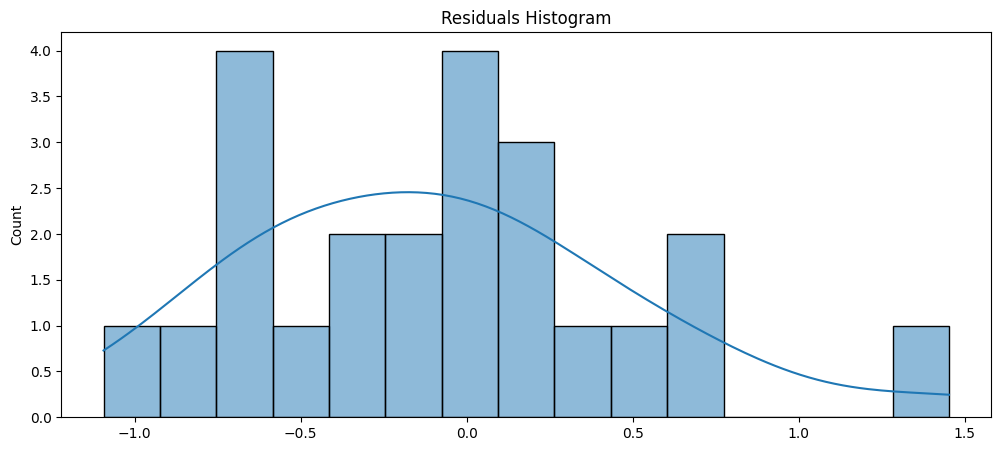

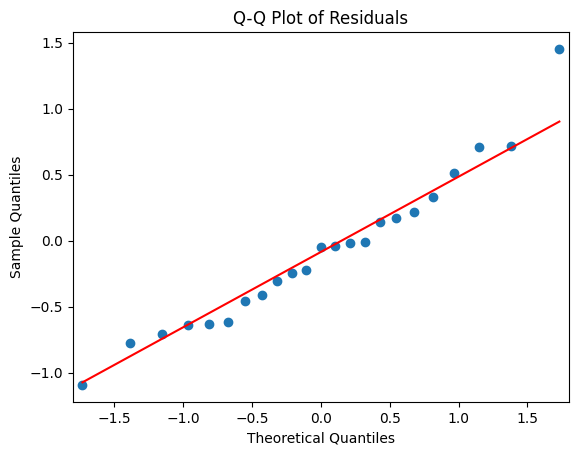

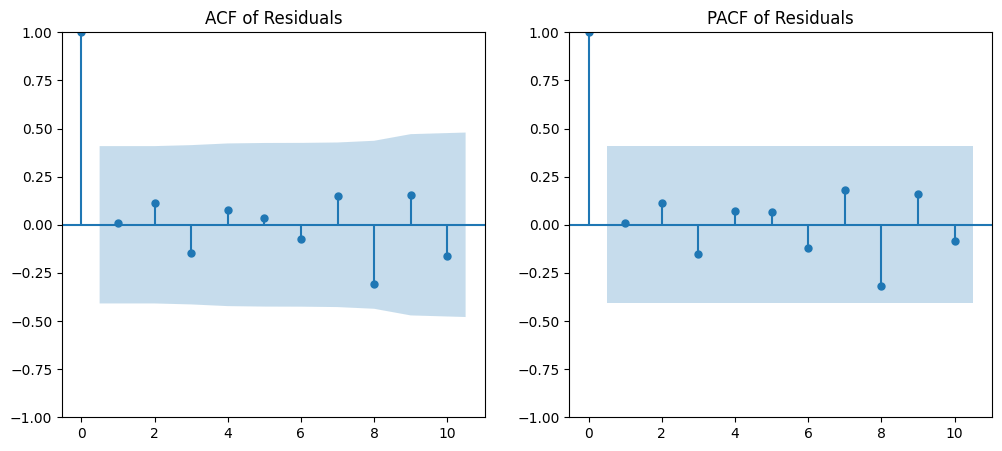

In [180]:
residuals = sarima_model.resid

plt.figure(figsize=(12, 5))
sns.histplot(residuals, bins=15, kde=True)
plt.title("Residuals Histogram")

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")

# ACF/PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(residuals, lags=10, ax=axes[0])
sm.graphics.tsa.plot_pacf(residuals, lags=10, ax=axes[1])
axes[0].set_title("ACF of Residuals")
axes[1].set_title("PACF of Residuals")

# 8. Forecast next 5 years

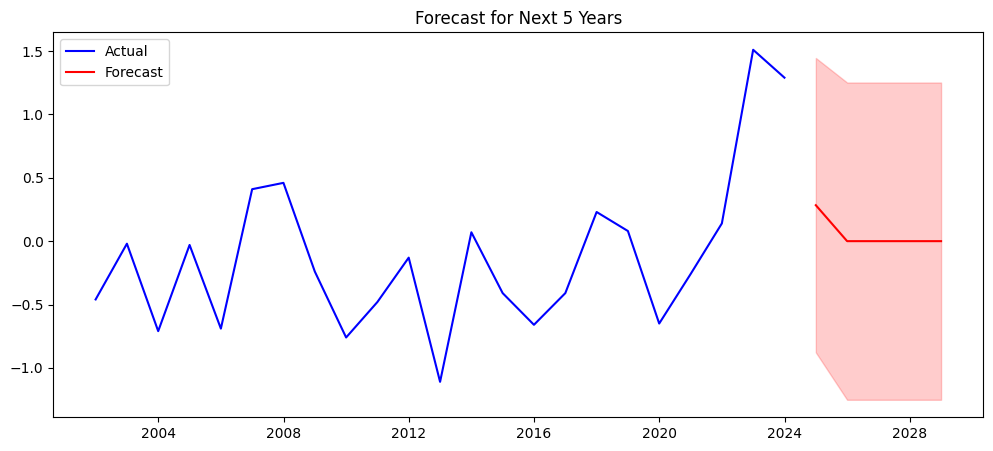

In [212]:
future_years = pd.date_range(start=df_copy.index[-1], periods=6, freq="YE")[1:]

forecast = sarima_model.get_forecast(steps=5)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 5))
plt.plot(df_copy.index, df_copy["Diff_German_Yield"], label="Actual", color="blue")
plt.plot(future_years, forecast_mean, label="Forecast", color="red")
plt.fill_between(future_years, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="red", alpha=0.2)
plt.legend()
plt.title("Forecast for Next 5 Years")
